In [7]:
%autoreload 2

UsageError: Line magic function `%autoreload` not found.


In [8]:
import numpy as np
from linear_regression import LinearRegression as LG

num_objects = 100
dimension = 5

x = np.random.rand(num_objects, dimension)
y = np.random.rand(num_objects)

In [9]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import LinearRegression as SklearnLinearRegression
import sklearn

sklearn_linreg = SklearnLinearRegression(fit_intercept=False)
sklearn_linreg.fit(x, y)
print("Sklearn MSE", mse(sklearn_linreg.predict(x), y))

your_linreg = LG(optimizer=None)
your_linreg.fit(x, y)
print("Your MSE", mse(your_linreg.predict(x), y))

assert abs(mse(your_linreg.predict(x), y) - mse(sklearn_linreg.predict(x), y)) < 1e-12, "Не повезло, попробуйте еще раз"

Sklearn MSE 0.09552558233603062
Your MSE 0.09552558233603063


In [10]:
x[:, 3] = x[:, 2] + x[:, 4]

In [11]:
sklearn_linreg = sklearn.linear_model.LinearRegression(fit_intercept=False)
sklearn_linreg.fit(x, y)
print("Sklearn MSE", mse(sklearn_linreg.predict(x), y))

your_linreg = LG(optimizer=None)
your_linreg.fit(x, y)

print("Your MSE", mse(your_linreg.predict(x), y))

Sklearn MSE 0.10488265653501616
Your MSE 0.10488265653501616


In [12]:
sklearn_linreg = sklearn.linear_model.LinearRegression(fit_intercept=False)
sklearn_linreg.fit(x, y)
print("Sklearn MSE", mse(sklearn_linreg.predict(x), y))

your_linreg = LG(optimizer="SVD")
your_linreg.fit(x, y)
print("Your MSE", mse(your_linreg.predict(x), y))

assert abs(mse(your_linreg.predict(x), y) - mse(sklearn_linreg.predict(x), y)) < 1e-12, "Не повезло, попробуйте еще раз"

Sklearn MSE 0.10488265653501616
Your MSE 0.10488265653501616


In [13]:
%load_ext autoreload

In [14]:
%autoreload 2

from descents import (
    VanillaGradientDescent,
    StochasticGradientDescent,
    SAGDescent,
    MomentumDescent,
    Adam
)

In [15]:
num_objects = 100
dimension = 5

x = np.random.rand(num_objects, dimension)
y = np.random.rand(num_objects)

In [16]:
# Если вы реализовали не все методы спуска, то уберите лишние из списка ниже
descent_models = [
    VanillaGradientDescent,
    StochasticGradientDescent,
    SAGDescent,
    MomentumDescent,
    Adam
]

max_iter = 10
tolerance = 0
num_objects = 100
dimension = 5

for descent_model in descent_models:
    optimizer = descent_model()
    model = LG(
        optimizer=optimizer,
        tolerance=tolerance,
        max_iter=max_iter,
    )
    model.fit(x, y)
    assert len(model.loss_history) == max_iter + 1, "Loss history failed"
    y_pred = model.predict(x)
    assert y_pred.shape == y.shape, "Prediction shape does not match target variable"

In [17]:
import numpy as np
import pandas as pd  # при желании, можете заменить на polars/pyspark или что угодно, что вам нравится

import matplotlib.pyplot as plt
import seaborn as sns

from descents import (
    ConstantLR, TimeDecayLR,
    VanillaGradientDescent, StochasticGradientDescent,
    MomentumDescent, Adam, SAGDescent
)
from linear_regression import LinearRegression

sns.set(style='darkgrid')

In [18]:
data = pd.read_csv('autos.csv')  # разумеется, если вы используете не pandas, это надо поменять

In [19]:
data.head()

,brand,model,vehicleType,gearbox,fuelType,notRepairedDamage,powerPS,kilometer,autoAgeMonths,price
0,volkswagen,golf,kleinwagen,manuell,benzin,nein,75,150000,177,1500
1,skoda,fabia,kleinwagen,manuell,diesel,nein,69,90000,93,3600
2,bmw,3er,limousine,manuell,benzin,ja,102,150000,246,650
3,peugeot,2_reihe,cabrio,manuell,benzin,nein,109,150000,140,2200
4,mazda,3_reihe,limousine,manuell,benzin,nein,105,150000,136,2000


Колонки в данных:

* `brand` - название бренда автомобиля
* `model` - название модели автомобиля
* `vehicleType` - тип транспортного средства
* `gearbox` - тип трансмисcии
* `fuelType` - какой вид топлива использует автомобиль
* `notRepairedDamage` - есть ли в автомобиле неисправность, которая еще не устранена
* `powerPS` - мощность автомобиля в PS (метрическая лошадиная сила)
* `kilometer` - сколько километров проехал автомобиль, пробег
* `autoAgeMonths` - возраст автомобиля в месяцах


* `price` - цена, указанная в объявлении о продаже автомобиля (целевая переменная)

In [20]:
categorical = []
numeric = []
other = []

# YOUR CODE (EDA):
for col in data.columns:
    if col == 'price':
        other.append(col)
        continue
        
    dtype = pd.api.types.infer_dtype(data[col])
    
    if dtype in ['string', 'object', 'mixed', 'categorical', 'boolean']:
        categorical.append(col)
    elif dtype in ['integer', 'floating', 'integer-na', 'floating-na']:
        if data[col].nunique() <= 15:
            categorical.append(col)
        else:
            numeric.append(col)
    else:
        numeric.append(col)

print(f"Категориальные ({len(categorical)}): {categorical}")
print(f"Числовые ({len(numeric)}): {numeric}")
print(f"Другие ({len(other)}): {other}")

Категориальные (7): ['brand', 'model', 'vehicleType', 'gearbox', 'fuelType', 'notRepairedDamage', 'kilometer']
Числовые (2): ['powerPS', 'autoAgeMonths']
Другие (1): ['price']


In [21]:
data['bias'] = 1
other += ['bias']

x = data[categorical + numeric + other]
y = data['price']

In [22]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler


column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('scaling', StandardScaler(), numeric),
    ('other',  'passthrough', other)
])

x = column_transformer.fit_transform(x)

In [23]:
from sklearn.model_selection import train_test_split

X_train_val, X_test, y_train_val, y_test = train_test_split(
    x, y,
    test_size = 0.1,
    random_state = 42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    test_size = 1/9,
    random_state = 49
)


print(f"Размеры выборок:")
print(f"Обучающая: {X_train.shape[0]} samples ({X_train.shape[0]/x.shape[0]*100:.1f}%)")
print(f"Валидационная: {X_val.shape[0]} samples ({X_val.shape[0]/x.shape[0]*100:.1f}%)")
print(f"Тестовая: {X_test.shape[0]} samples ({X_test.shape[0]/x.shape[0]*100:.1f}%)")

Размеры выборок:
Обучающая: 192952 samples (80.0%)
Валидационная: 24119 samples (10.0%)
Тестовая: 24119 samples (10.0%)


Подбор параметров для VanillaGD


VanillaGD: 100%|███████████████████████████████████████████████████████████████████████| 15/15 [11:56<00:00, 47.79s/it]


Подбор параметров для StochasticGD


StochasticGD: 100%|████████████████████████████████████████████████████████████████████| 15/15 [04:15<00:00, 17.05s/it]


Подбор параметров для Momentum


Momentum: 100%|████████████████████████████████████████████████████████████████████████| 15/15 [12:01<00:00, 48.09s/it]


Подбор параметров для Adam


Adam: 100%|████████████████████████████████████████████████████████████████████████████| 15/15 [06:30<00:00, 26.05s/it]


Подбор параметров для SAG


SAG: 100%|█████████████████████████████████████████████████████████████████████████████| 15/15 [01:26<00:00,  5.78s/it]


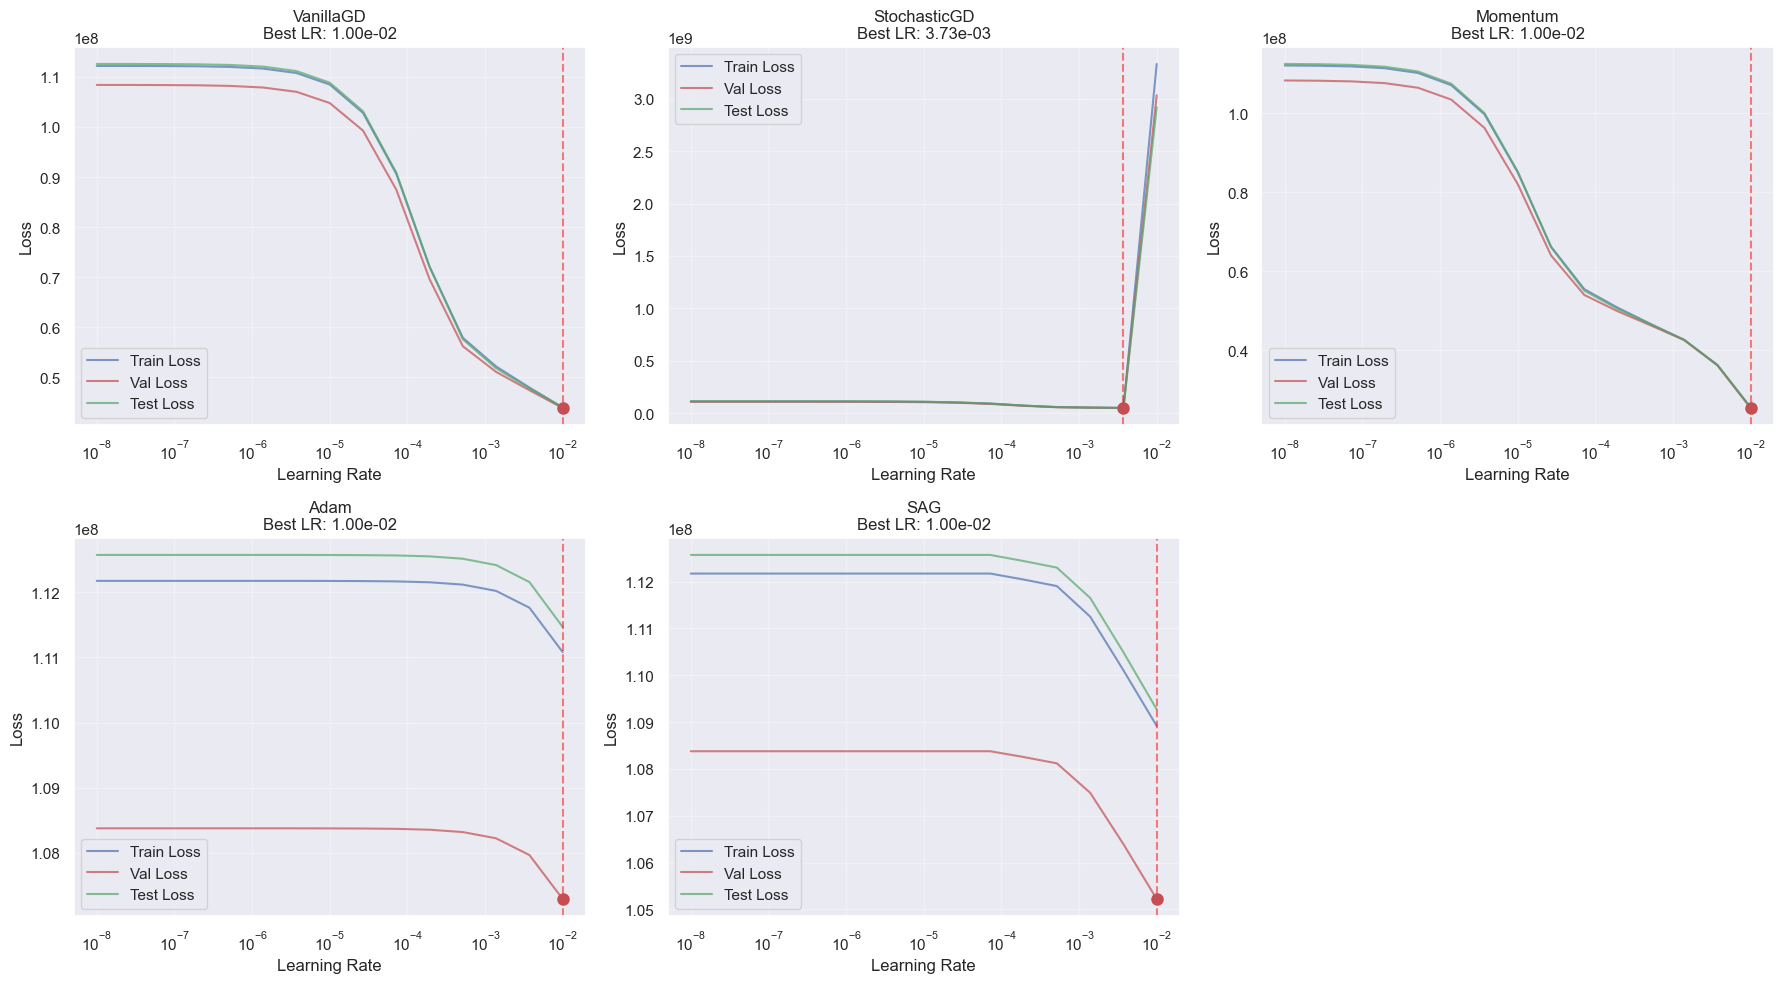


Сводная таблица
      Method  Best LR       Val Loss  Val R²      Test Loss Test R²  Iterations
   VanillaGD 1.00e-02  43894582.0627  0.2825  43982719.8966  0.3174         500
StochasticGD 3.73e-03  48800895.8296  0.2023  48952449.0385  0.2402         500
    Momentum 1.00e-02  25385647.6383  0.5850  25530271.7844  0.6038         500
        Adam 1.00e-02 107294244.6219 -0.7539 111464933.6660 -0.7300         500
         SAG 1.00e-02 105222630.0407 -0.7200 109271634.5373 -0.6959         500


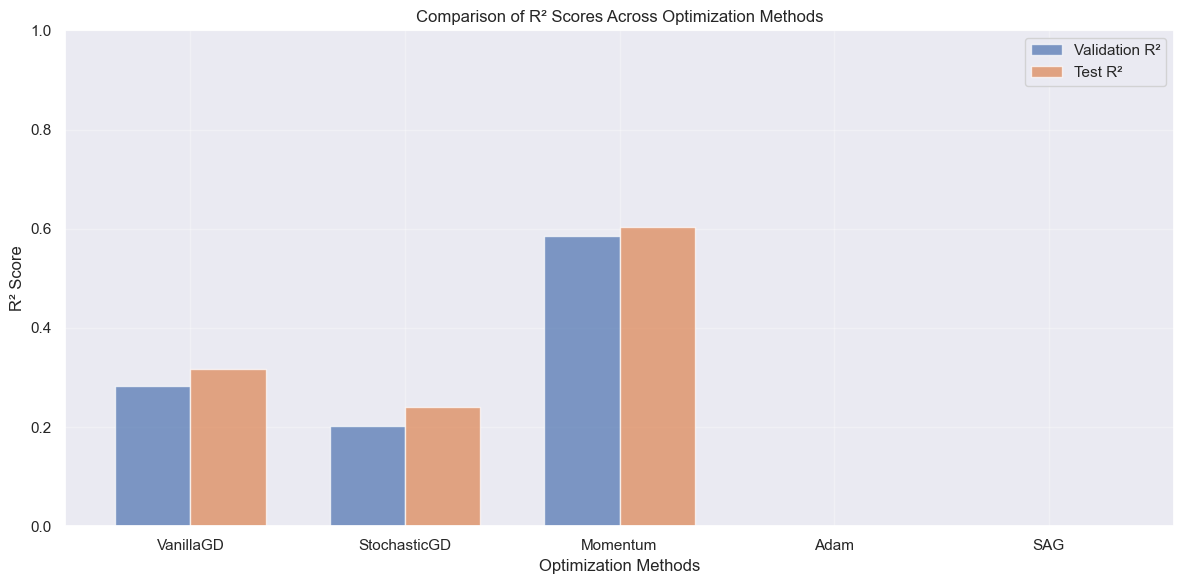

In [24]:
import numpy as np
from tqdm import tqdm
from linear_regression import LossFunction

X_train_np = X_train.toarray() if hasattr(X_train, 'toarray') else np.array(X_train)
X_val_np = X_val.toarray() if hasattr(X_val, 'toarray') else np.array(X_val)
X_test_np = X_test.toarray() if hasattr(X_test, 'toarray') else np.array(X_test)
y_train_np = np.array(y_train)
y_val_np = np.array(y_val)
y_test_np = np.array(y_test)

if 'bias' in data.columns:
    bias_idx = data.columns.get_loc('bias')

    X_train_scaled = X_train_np.copy()
    X_val_scaled = X_val_np.copy()
    X_test_scaled = X_test_np.copy()

    feature_means = np.mean(X_train_np, axis=0)
    feature_stds = np.std(X_train_np, axis=0)

    feature_stds[feature_stds == 0] = 1
    
    mask = np.ones(X_train_np.shape[1], dtype=bool)
    if bias_idx < X_train_np.shape[1]:
        mask[bias_idx] = False
    
    X_train_scaled[:, mask] = (X_train_np[:, mask] - feature_means[mask]) / feature_stds[mask]
    X_val_scaled[:, mask] = (X_val_np[:, mask] - feature_means[mask]) / feature_stds[mask]
    X_test_scaled[:, mask] = (X_test_np[:, mask] - feature_means[mask]) / feature_stds[mask]
else:
    X_train_scaled = X_train_np
    X_val_scaled = X_val_np
    X_test_scaled = X_test_np

optimizers = {
    'VanillaGD': VanillaGradientDescent,
    'StochasticGD': StochasticGradientDescent,
    'Momentum': MomentumDescent,
    'Adam': Adam,
    'SAG': SAGDescent
}

lr_values = np.logspace(-8, -2, 15)

results = {}

for opt_name, opt_class in optimizers.items():
    print(f"Подбор параметров для {opt_name}")
    
    train_losses = []
    val_losses = []
    test_losses = []
    train_scores = []
    val_scores = []
    test_scores = []
    iterations_list = []
    
    for lr_val in tqdm(lr_values, desc=opt_name):
        class CustomConstantLR(ConstantLR):
            def __init__(self):
                super().__init__(lr=lr_val)
        
        try:
            if opt_name == 'StochasticGD':
                optimizer = opt_class(lr_schedule=CustomConstantLR, batch_size=64)
            elif opt_name == 'Momentum':
                optimizer = opt_class(lr_schedule=CustomConstantLR, beta=0.9)
            elif opt_name == 'Adam':
                optimizer = opt_class(lr_schedule=CustomConstantLR, beta1=0.9, beta2=0.999, eps=1e-8)
            else:
                optimizer = opt_class(lr_schedule=CustomConstantLR)

            model = LinearRegression(
                optimizer=optimizer,
                tolerance=1e-4,
                max_iter=500, 
                loss_function=LossFunction.MSE
            )
            
            model.fit(X_train_scaled, y_train_np)
            iterations = len(model.loss_history) - 1
            iterations_list.append(iterations)

            train_loss = model.compute_loss(X_train_scaled, y_train_np)
            val_loss = model.compute_loss(X_val_scaled, y_val_np)
            test_loss = model.compute_loss(X_test_scaled, y_test_np)

            if not (np.isfinite(train_loss) and np.isfinite(val_loss) and np.isfinite(test_loss)):
                raise ValueError("Non-finite loss value")
                
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            test_losses.append(test_loss)

            train_score = model.score(X_train_scaled, y_train_np)
            val_score = model.score(X_val_scaled, y_val_np)
            test_score = model.score(X_test_scaled, y_test_np)
            
            train_scores.append(train_score)
            val_scores.append(val_score)
            test_scores.append(test_score)
            
        except Exception as e:
            train_losses.append(np.inf)
            val_losses.append(np.inf)
            test_losses.append(np.inf)
            train_scores.append(-np.inf)
            val_scores.append(-np.inf)
            test_scores.append(-np.inf)
            iterations_list.append(500)

    valid_indices = [i for i, loss in enumerate(val_losses) if np.isfinite(loss)]
    if valid_indices:
        best_idx = valid_indices[np.argmin([val_losses[i] for i in valid_indices])]
        best_lr = lr_values[best_idx]
    else:
        best_idx = 0
        best_lr = lr_values[0]
        print(f"Warning: No valid results for {opt_name}")
    
    results[opt_name] = {
        'lr_values': lr_values.copy(),
        'train_losses': train_losses,
        'val_losses': val_losses,
        'test_losses': test_losses,
        'train_scores': train_scores,
        'val_scores': val_scores,
        'test_scores': test_scores,
        'iterations': iterations_list,
        'best_lr': best_lr,
        'best_val_loss': val_losses[best_idx] if valid_indices else np.inf,
        'best_val_score': val_scores[best_idx] if valid_indices else -np.inf,
        'best_test_loss': test_losses[best_idx] if valid_indices else np.inf,
        'best_test_score': test_scores[best_idx] if valid_indices else -np.inf,
        'best_iterations': iterations_list[best_idx]
    }

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, (opt_name, result) in enumerate(results.items()):
    ax = axes[idx]
    valid_mask = np.isfinite(result['val_losses'])
    lr_vals = result['lr_values'][valid_mask]
    train_losses = np.array(result['train_losses'])[valid_mask]
    val_losses = np.array(result['val_losses'])[valid_mask]
    test_losses = np.array(result['test_losses'])[valid_mask]
    
    if len(lr_vals) > 0:
        ax.semilogx(lr_vals, train_losses, 'b-', label='Train Loss', alpha=0.7)
        ax.semilogx(lr_vals, val_losses, 'r-', label='Val Loss', alpha=0.7)
        ax.semilogx(lr_vals, test_losses, 'g-', label='Test Loss', alpha=0.7)

        best_lr = result['best_lr']
        best_val_loss = result['best_val_loss']
        if np.isfinite(best_val_loss):
            ax.axvline(x=best_lr, color='red', linestyle='--', alpha=0.5)
            ax.plot(best_lr, best_val_loss, 'ro', markersize=8)
    
    ax.set_title(f'{opt_name}\nBest LR: {result["best_lr"]:.2e}')
    ax.set_xlabel('Learning Rate')
    ax.set_ylabel('Loss')
    if len(lr_vals) > 0:
        ax.legend()
    ax.grid(True, alpha=0.3)

axes[-1].axis('off')

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("Сводная таблица")
print("="*80)

summary_data = []
for opt_name, result in results.items():
    if np.isfinite(result['best_val_loss']):
        summary_data.append({
            'Method': opt_name,
            'Best LR': f"{result['best_lr']:.2e}",
            'Val Loss': f"{result['best_val_loss']:.4f}",
            'Val R²': f"{result['best_val_score']:.4f}",
            'Test Loss': f"{result['best_test_loss']:.4f}",
            'Test R²': f"{result['best_test_score']:.4f}",
            'Iterations': result['best_iterations']
        })

if summary_data:
    summary_df = pd.DataFrame(summary_data)
    print(summary_df.to_string(index=False))
else:
    print("No valid results for any method!")

valid_methods = [m for m in results.keys() if np.isfinite(results[m]['best_val_score'])]
if valid_methods:
    plt.figure(figsize=(12, 6))
    
    val_scores = [results[method]['best_val_score'] for method in valid_methods]
    test_scores = [results[method]['best_test_score'] for method in valid_methods]
    
    x = np.arange(len(valid_methods))
    width = 0.35
    
    plt.bar(x - width/2, val_scores, width, label='Validation R²', alpha=0.7)
    plt.bar(x + width/2, test_scores, width, label='Test R²', alpha=0.7)
    
    plt.xlabel('Optimization Methods')
    plt.ylabel('R² Score')
    plt.title('Comparison of R² Scores Across Optimization Methods')
    plt.xticks(x, valid_methods)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 1)
    
    plt.tight_layout()
    plt.show()

Обучение VanillaGD с LR=1.00e-02
Обучение StochasticGD с LR=3.73e-03
Обучение Momentum с LR=1.00e-02
Обучение Adam с LR=1.00e-02
Обучение SAG с LR=1.00e-02


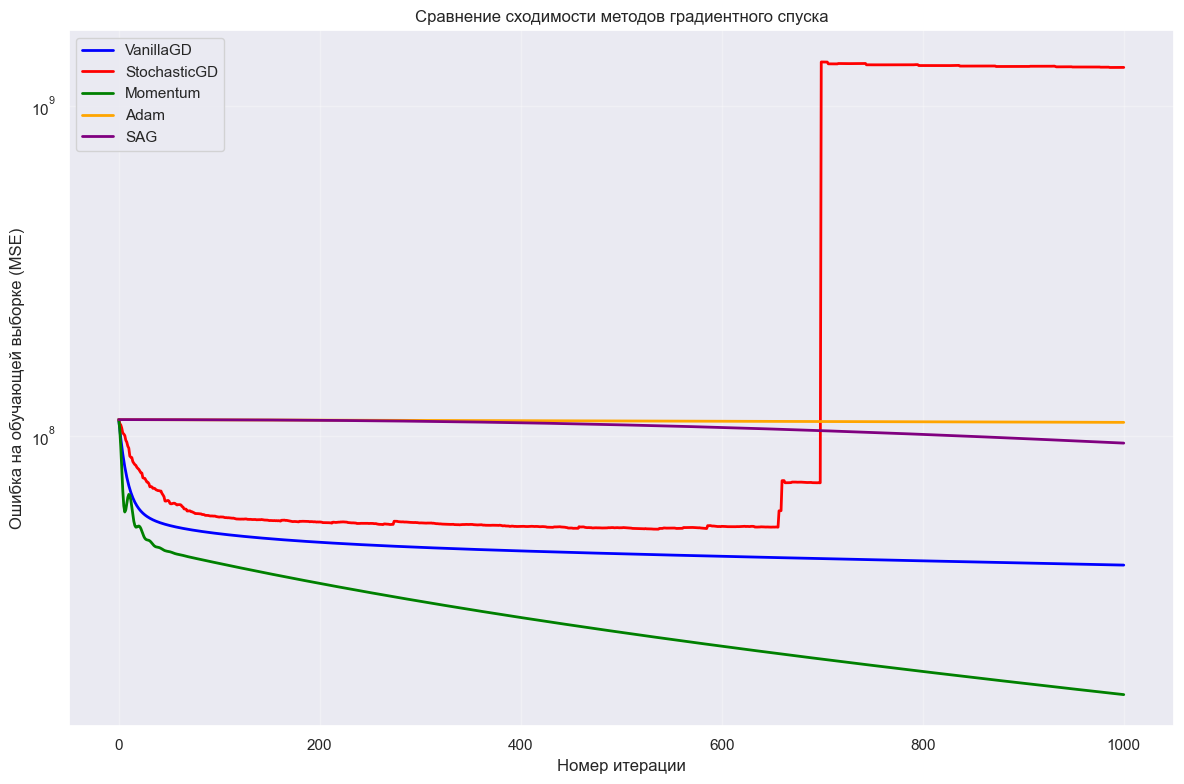

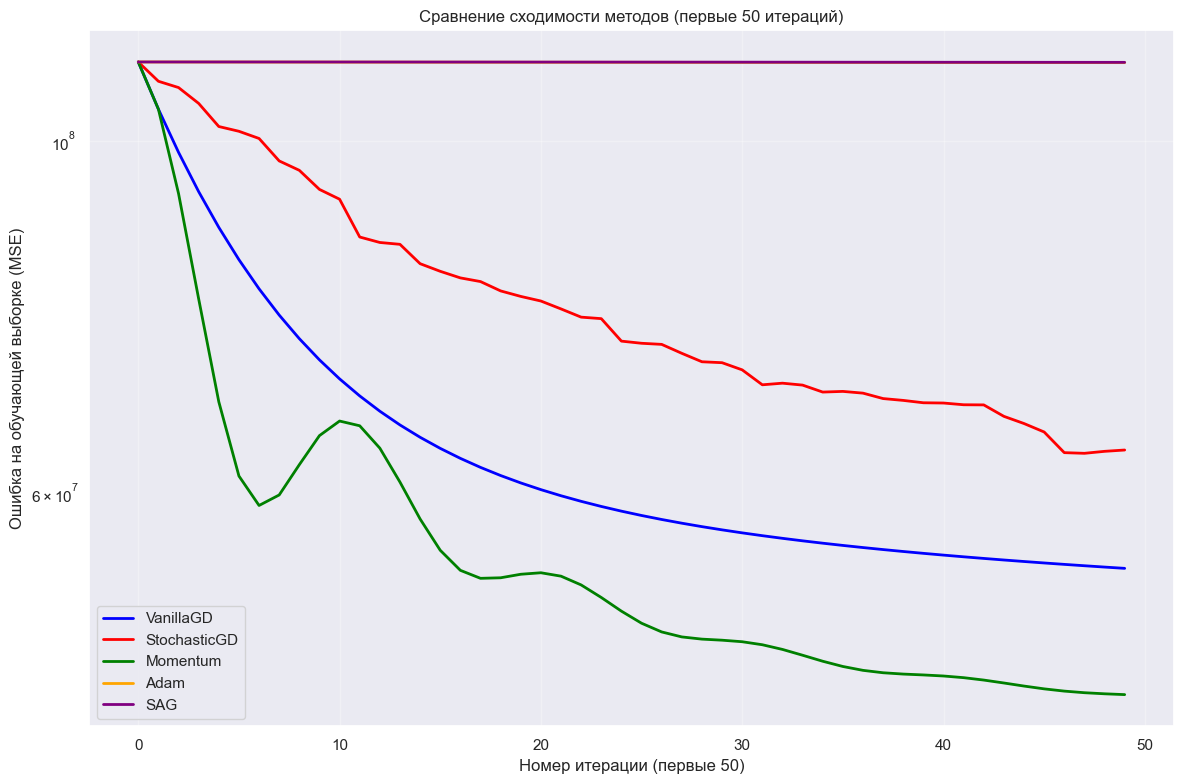


Анализ результатов
Сводка по сходимости:
      Method  Final Train Loss  Iterations to Converge Converged
   VanillaGD   40677110.004059                    1000        No
StochasticGD 1306456879.567697                    1000        No
    Momentum   16490102.339095                    1000        No
        Adam  110022227.372253                    1000        No
         SAG   95208308.011898                    1000        No

Сравнительный анализ методов:
1. Скорость сходимости:
   - VanillaGD: 1000 итераций
   - StochasticGD: 1000 итераций
   - Momentum: 1000 итераций
   - Adam: 1000 итераций
   - SAG: 1000 итераций

2. Качество сходимости (финальная ошибка):
   - Лучший метод: Momentum (MSE = 16490102.339095)

3. Стабильность сходимости:
   - VanillaGD: начальная скорость = 4137930.9116
   - StochasticGD: начальная скорость = 2027204.1428
   - Momentum: начальная скорость = 4558541.7414
   - Adam: начальная скорость = 2221.9285
   - SAG: начальная скорость = 617.7643


In [26]:
best_lr_params = {
    'VanillaGD': results['VanillaGD']['best_lr'],
    'StochasticGD': results['StochasticGD']['best_lr'], 
    'Momentum': results['Momentum']['best_lr'],
    'Adam': results['Adam']['best_lr'],
    'SAG': results['SAG']['best_lr']
}

convergence_history = {}

for opt_name, best_lr in best_lr_params.items():
    print(f"Обучение {opt_name} с LR={best_lr:.2e}")

    class BestConstantLR(ConstantLR):
        def __init__(self):
            super().__init__(lr=best_lr)

    if opt_name == 'StochasticGD':
        optimizer = optimizers[opt_name](lr_schedule=BestConstantLR, batch_size=32)
    elif opt_name == 'Momentum':
        optimizer = optimizers[opt_name](lr_schedule=BestConstantLR, beta=0.9)
    elif opt_name == 'Adam':
        optimizer = optimizers[opt_name](lr_schedule=BestConstantLR, beta1=0.9, beta2=0.999, eps=1e-8)
    else:
        optimizer = optimizers[opt_name](lr_schedule=BestConstantLR)

    model = LinearRegression(
        optimizer=optimizer,
        tolerance=1e-6,
        max_iter=1000,
        loss_function=LossFunction.MSE
    )
    
    model.fit(X_train_scaled, y_train_np)

    convergence_history[opt_name] = model.loss_history

plt.figure(figsize=(12, 8))

colors = {'VanillaGD': 'blue', 'StochasticGD': 'red', 'Momentum': 'green', 
          'Adam': 'orange', 'SAG': 'purple'}

for opt_name, losses in convergence_history.items():
    iterations = range(len(losses))
    plt.plot(iterations, losses, label=opt_name, color=colors[opt_name], linewidth=2)
    if len(losses) < 1000:
        plt.plot(len(losses)-1, losses[-1], 'o', color=colors[opt_name], markersize=8)

plt.xlabel('Номер итерации')
plt.ylabel('Ошибка на обучающей выборке (MSE)')
plt.title('Сравнение сходимости методов градиентного спуска')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log') 
plt.tight_layout()
plt.show()
plt.figure(figsize=(12, 8))

for opt_name, losses in convergence_history.items():
    iterations = range(min(50, len(losses)))
    plt.plot(iterations, losses[:50], label=opt_name, color=colors[opt_name], linewidth=2)

plt.xlabel('Номер итерации (первые 50)')
plt.ylabel('Ошибка на обучающей выборке (MSE)')
plt.title('Сравнение сходимости методов (первые 50 итераций)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("Анализ результатов")
print("="*80)

convergence_summary = []
for opt_name, losses in convergence_history.items():
    final_loss = losses[-1]
    iterations_to_converge = len(losses) - 1
    convergence_summary.append({
        'Method': opt_name,
        'Final Train Loss': f"{final_loss:.6f}",
        'Iterations to Converge': iterations_to_converge,
        'Converged': 'Yes' if iterations_to_converge < 1000 else 'No'
    })

convergence_df = pd.DataFrame(convergence_summary)
print("Сводка по сходимости:")
print(convergence_df.to_string(index=False))

print("\nСравнительный анализ методов:")
print("1. Скорость сходимости:")
for opt_name, losses in convergence_history.items():
    print(f"   - {opt_name}: {len(losses)-1} итераций")

print("\n2. Качество сходимости (финальная ошибка):")  
best_method = min(convergence_history.items(), key=lambda x: x[1][-1])
print(f"   - Лучший метод: {best_method[0]} (MSE = {best_method[1][-1]:.6f})")

print("\n3. Стабильность сходимости:")
for opt_name, losses in convergence_history.items():
    if len(losses) > 10:
        initial_slope = (losses[0] - losses[10]) / 10
        print(f"   - {opt_name}: начальная скорость = {initial_slope:.4f}")

Исследование размера батча для SGD с LR=1.00e-02


Batch Sizes: 100%|███████████████████████████████████████████████████████████████████████| 8/8 [04:00<00:00, 30.09s/it]


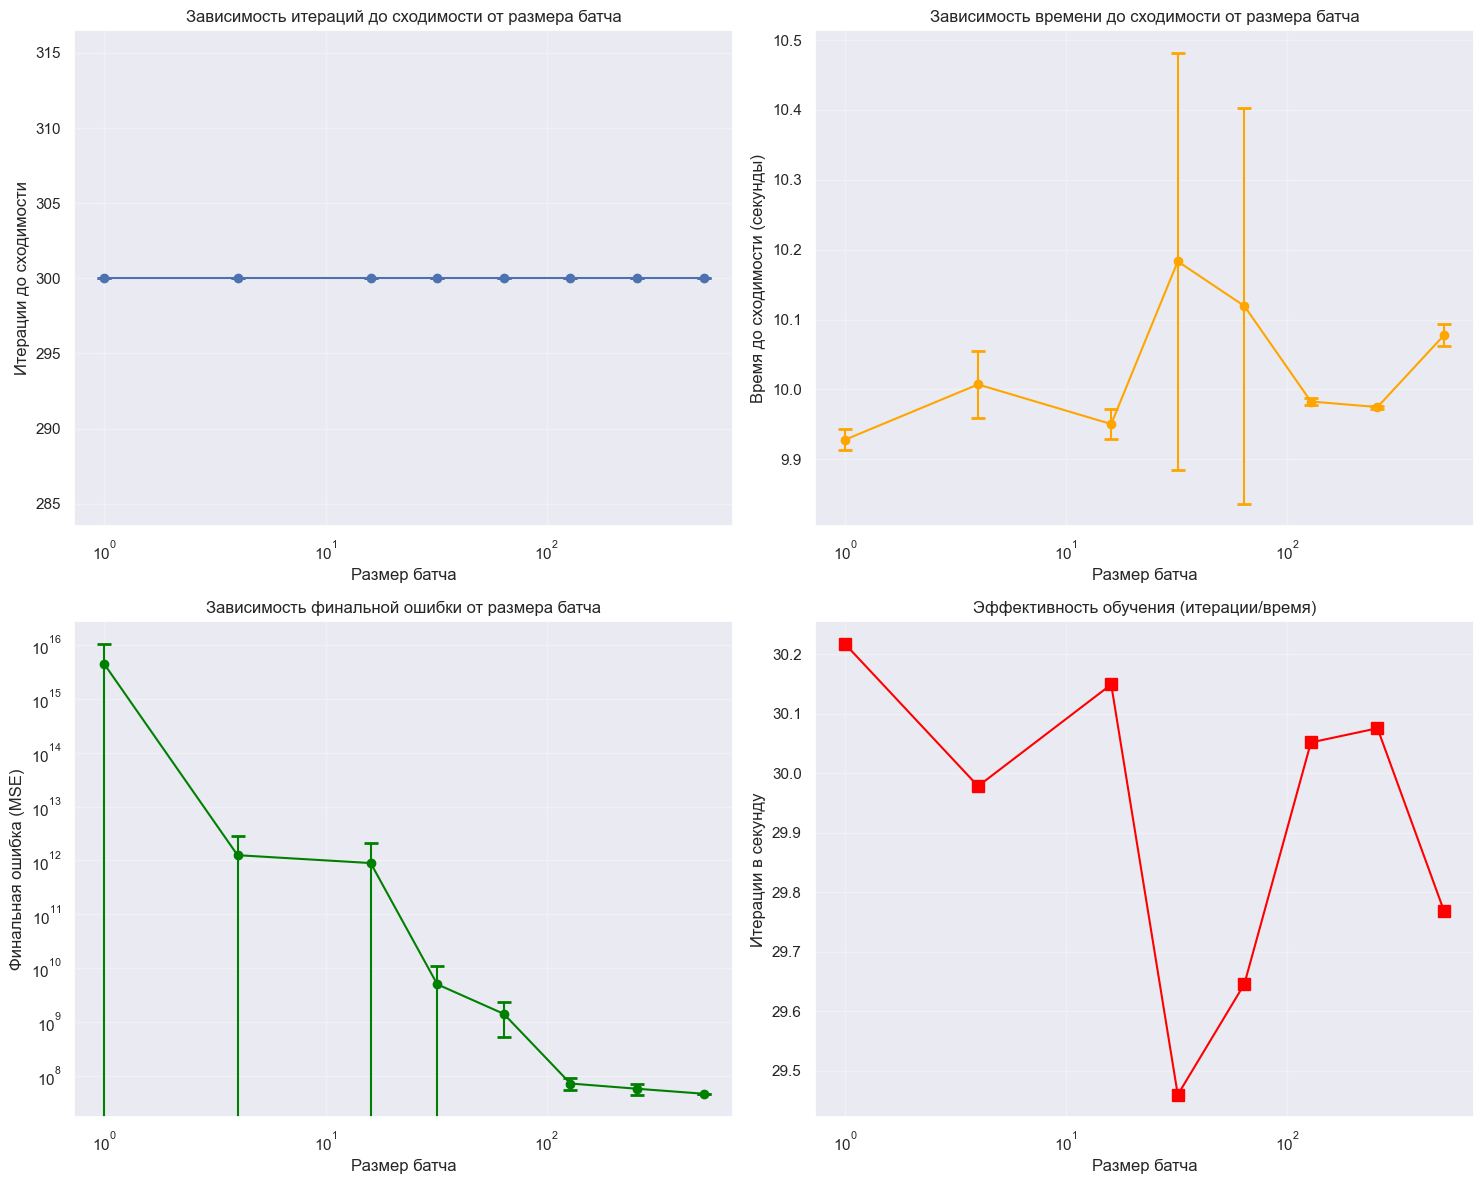


Детальные результаты
 Batch Size Iterations     Time (s)              Final Loss Iter/s
          1  300 ± 0.0  9.93 ± 0.01 4372427328623474.000000   30.2
          4  300 ± 0.0 10.01 ± 0.05    1249232910690.787598   30.0
         16  300 ± 0.0  9.95 ± 0.02     892152339159.993652   30.1
         32  300 ± 0.0 10.18 ± 0.30       5011674204.860420   29.5
         64  300 ± 0.0 10.12 ± 0.28       1415003543.672732   29.6
        128  300 ± 0.0  9.98 ± 0.00         72180729.355358   30.1
        256  300 ± 0.0  9.97 ± 0.00         57686247.596955   30.1
        512  300 ± 0.0 10.08 ± 0.02         46641219.356363   29.8

Анализ результатов и выводы
Оптимальные значения:
1. Минимальное количество итераций: batch_size = 1.0
   - Итерации: 300
   - Время: 9.93 сек

2. Минимальное время обучения: batch_size = 1.0
   - Итерации: 300
   - Время: 9.93 сек

3. Лучшая точность: batch_size = 512.0
   - Final Loss: 46641219.356363

Основыне тренды:
1. Зависимость итераций от размера батча:
   - Увел

In [27]:
import time
import numpy as np
from tqdm import tqdm
from linear_regression import LossFunction

batch_sizes = [1, 4, 16, 32, 64, 128, 256, 512]
n_runs = 3
max_iter = 300
best_lr_sgd = 0.01

print(f"Исследование размера батча для SGD с LR={best_lr_sgd:.2e}")
print("=" * 60)

batch_results = {
    'batch_size': [],
    'iterations_mean': [],
    'iterations_std': [],
    'time_mean': [],
    'time_std': [],
    'final_loss_mean': [],
    'final_loss_std': []
}

for batch_size in tqdm(batch_sizes, desc="Batch Sizes"):
    iterations_list = []
    time_list = []
    final_loss_list = []
    
    for run in range(n_runs):
        class BestConstantLR(ConstantLR):
            def __init__(self):
                super().__init__(lr=best_lr_sgd)

        optimizer = StochasticGradientDescent(lr_schedule=BestConstantLR, batch_size=batch_size)

        model = LinearRegression(
            optimizer=optimizer,
            tolerance=1e-3,
            max_iter=max_iter,
            loss_function=LossFunction.MSE
        )

        start_time = time.time()
        model.fit(X_train_scaled, y_train_np)
        end_time = time.time()

        iterations = len(model.loss_history) - 1
        final_loss = model.loss_history[-1] if model.loss_history else np.inf
        
        iterations_list.append(iterations)
        time_list.append(end_time - start_time)
        final_loss_list.append(final_loss)

    batch_results['batch_size'].append(batch_size)
    batch_results['iterations_mean'].append(np.mean(iterations_list))
    batch_results['iterations_std'].append(np.std(iterations_list))
    batch_results['time_mean'].append(np.mean(time_list))
    batch_results['time_std'].append(np.std(time_list))
    batch_results['final_loss_mean'].append(np.mean(final_loss_list))
    batch_results['final_loss_std'].append(np.std(final_loss_list))

batch_df = pd.DataFrame(batch_results)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

ax1 = axes[0, 0]
ax1.errorbar(batch_df['batch_size'], batch_df['iterations_mean'], 
             yerr=batch_df['iterations_std'], fmt='o-', capsize=5, capthick=2)
ax1.set_xscale('log')
ax1.set_xlabel('Размер батча')
ax1.set_ylabel('Итерации до сходимости')
ax1.set_title('Зависимость итераций до сходимости от размера батча')
ax1.grid(True, alpha=0.3)

ax2 = axes[0, 1]
ax2.errorbar(batch_df['batch_size'], batch_df['time_mean'], 
             yerr=batch_df['time_std'], fmt='o-', capsize=5, capthick=2, color='orange')
ax2.set_xscale('log')
ax2.set_xlabel('Размер батча')
ax2.set_ylabel('Время до сходимости (секунды)')
ax2.set_title('Зависимость времени до сходимости от размера батча')
ax2.grid(True, alpha=0.3)

ax3 = axes[1, 0]
ax3.errorbar(batch_df['batch_size'], batch_df['final_loss_mean'], 
             yerr=batch_df['final_loss_std'], fmt='o-', capsize=5, capthick=2, color='green')
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xlabel('Размер батча')
ax3.set_ylabel('Финальная ошибка (MSE)')
ax3.set_title('Зависимость финальной ошибки от размера батча')
ax3.grid(True, alpha=0.3)

ax4 = axes[1, 1]
efficiency = batch_df['iterations_mean'] / batch_df['time_mean']
ax4.plot(batch_df['batch_size'], efficiency, 's-', color='red', markersize=8)
ax4.set_xscale('log')
ax4.set_xlabel('Размер батча')
ax4.set_ylabel('Итерации в секунду')
ax4.set_title('Эффективность обучения (итерации/время)')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("Детальные результаты")
print("="*80)

detailed_results = []
for i, batch_size in enumerate(batch_sizes):
    detailed_results.append({
        'Batch Size': batch_size,
        'Iterations': f"{batch_results['iterations_mean'][i]:.0f} ± {batch_results['iterations_std'][i]:.1f}",
        'Time (s)': f"{batch_results['time_mean'][i]:.2f} ± {batch_results['time_std'][i]:.2f}",
        'Final Loss': f"{batch_results['final_loss_mean'][i]:.6f}",
        'Iter/s': f"{batch_results['iterations_mean'][i] / batch_results['time_mean'][i]:.1f}"
    })

detailed_df = pd.DataFrame(detailed_results)
print(detailed_df.to_string(index=False))

print("\n" + "="*80)
print("Анализ результатов и выводы")
print("="*80)

if not batch_df.empty:
    optimal_iterations = batch_df.loc[batch_df['iterations_mean'].idxmin()]
    optimal_time = batch_df.loc[batch_df['time_mean'].idxmin()]
    optimal_loss = batch_df.loc[batch_df['final_loss_mean'].idxmin()]

    print("Оптимальные значения:")
    print(f"1. Минимальное количество итераций: batch_size = {optimal_iterations['batch_size']}")
    print(f"   - Итерации: {optimal_iterations['iterations_mean']:.0f}")
    print(f"   - Время: {optimal_iterations['time_mean']:.2f} сек")

    print(f"\n2. Минимальное время обучения: batch_size = {optimal_time['batch_size']}")
    print(f"   - Итерации: {optimal_time['iterations_mean']:.0f}")
    print(f"   - Время: {optimal_time['time_mean']:.2f} сек")

    print(f"\n3. Лучшая точность: batch_size = {optimal_loss['batch_size']}")
    print(f"   - Final Loss: {optimal_loss['final_loss_mean']:.6f}")

    print("\nОсновыне тренды:")
    print("1. Зависимость итераций от размера батча:")
    if batch_df['iterations_mean'].iloc[0] > batch_df['iterations_mean'].iloc[-1]:
        print("   - Уменьшение размера батча → увеличение итераций")
    else:
        print("   - Увеличение размера батча → увеличение итераций")

    print("\n2. Зависимость времени от размера батча:")
    if batch_df['time_mean'].iloc[0] > batch_df['time_mean'].iloc[-1]:
        print("   - Уменьшение размера батча → увеличение времени")
    else:
        print("   - Увеличение размера батча → увеличение времени")

    print("\n3. Зависимость точности от размера батча:")
    loss_variation = (batch_df['final_loss_mean'].max() - batch_df['final_loss_mean'].min()) / batch_df['final_loss_mean'].min()
    print(f"   - Вариация точности: {loss_variation:.2%}")

    # Компромиссный анализ
    compromise_scores = []
    for i in range(len(batch_df)):
        if (batch_df['iterations_mean'].iloc[i] > 0 and 
            batch_df['time_mean'].iloc[i] > 0 and 
            batch_df['final_loss_mean'].iloc[i] > 0):
            
            norm_iter = batch_df['iterations_mean'].iloc[i] / batch_df['iterations_mean'].max()
            norm_time = batch_df['time_mean'].iloc[i] / batch_df['time_mean'].max() 
            norm_loss = batch_df['final_loss_mean'].iloc[i] / batch_df['final_loss_mean'].min()
            
            score = 0.4 * norm_iter + 0.4 * norm_time + 0.2 * norm_loss
            compromise_scores.append(score)
        else:
            compromise_scores.append(np.inf)

    if len(compromise_scores) > 0 and not all(np.isinf(compromise_scores)):
        best_compromise_idx = np.argmin(compromise_scores)
        best_compromise = batch_df.iloc[best_compromise_idx]
        print(f"\n4. Рекомендуемый компромисс: batch_size = {best_compromise['batch_size']}")
        print(f"   - Итерации: {best_compromise['iterations_mean']:.0f}")
        print(f"   - Время: {best_compromise['time_mean']:.2f} сек")
        print(f"   - Точность: {best_compromise['final_loss_mean']:.6f}")


Подбор параметров для VanillaGD с регуляризацией


VanillaGD - lambda: 100%|███████████████████████████████████████████████████████████████| 8/8 [46:21<00:00, 347.67s/it]


Лучшие параметры для VanillaGD: λ=1.00e-02, μ=1.00e-04
Val Loss: 43903755.1975, Iterations: 500

Подбор параметров для StochasticGD с регуляризацией


StochasticGD - lambda: 100%|████████████████████████████████████████████████████████████| 8/8 [17:46<00:00, 133.34s/it]


Лучшие параметры для StochasticGD: λ=2.68e-03, μ=7.20e-04
Val Loss: 51051135.3743, Iterations: 500

Подбор параметров для Momentum с регуляризацией


Momentum - lambda: 100%|████████████████████████████████████████████████████████████████| 8/8 [44:38<00:00, 334.82s/it]


Лучшие параметры для Momentum: λ=1.00e-02, μ=1.00e-04
Val Loss: 25566225.8249, Iterations: 500

Подбор параметров для Adam с регуляризацией


Adam - lambda: 100%|████████████████████████████████████████████████████████████████████| 8/8 [38:24<00:00, 288.07s/it]


Лучшие параметры для Adam: λ=1.00e-02, μ=1.00e-04
Val Loss: 107294245.8857, Iterations: 500

Подбор параметров для SAG с регуляризацией


SAG - lambda: 100%|██████████████████████████████████████████████████████████████████████| 8/8 [04:46<00:00, 35.85s/it]


Лучшие параметры для SAG: λ=1.00e-02, μ=1.93e+00
Val Loss: 102272140.2037, Iterations: 500

Сравение результатов с регуляризацией и без
      Method λ (no reg)  λ (reg)        μ Train Loss (no reg) Train Loss (reg) Test Loss (no reg) Test Loss (reg) Test R² (no reg) Test R² (reg)  Iterations (no reg)  Iterations (reg)
   VanillaGD   1.00e-02 1.00e-02 1.00e-04       43894582.0627    44021090.0497      43982719.8966   43992068.9713           0.3174        0.3173                  500               500
StochasticGD   3.73e-03 2.68e-03 7.20e-04       48800895.8296    53446759.3155      48952449.0385   51294563.8421           0.2402        0.2043                  500               500
    Momentum   1.00e-02 1.00e-02 1.00e-04       25385647.6383    25625806.3818      25530271.7844   25710235.0872           0.6038        0.6027                  500               500
        Adam   1.00e-02 1.00e-02 1.00e-04      107294244.6219   111079562.9798     111464933.6660  111464934.7365          -0.73

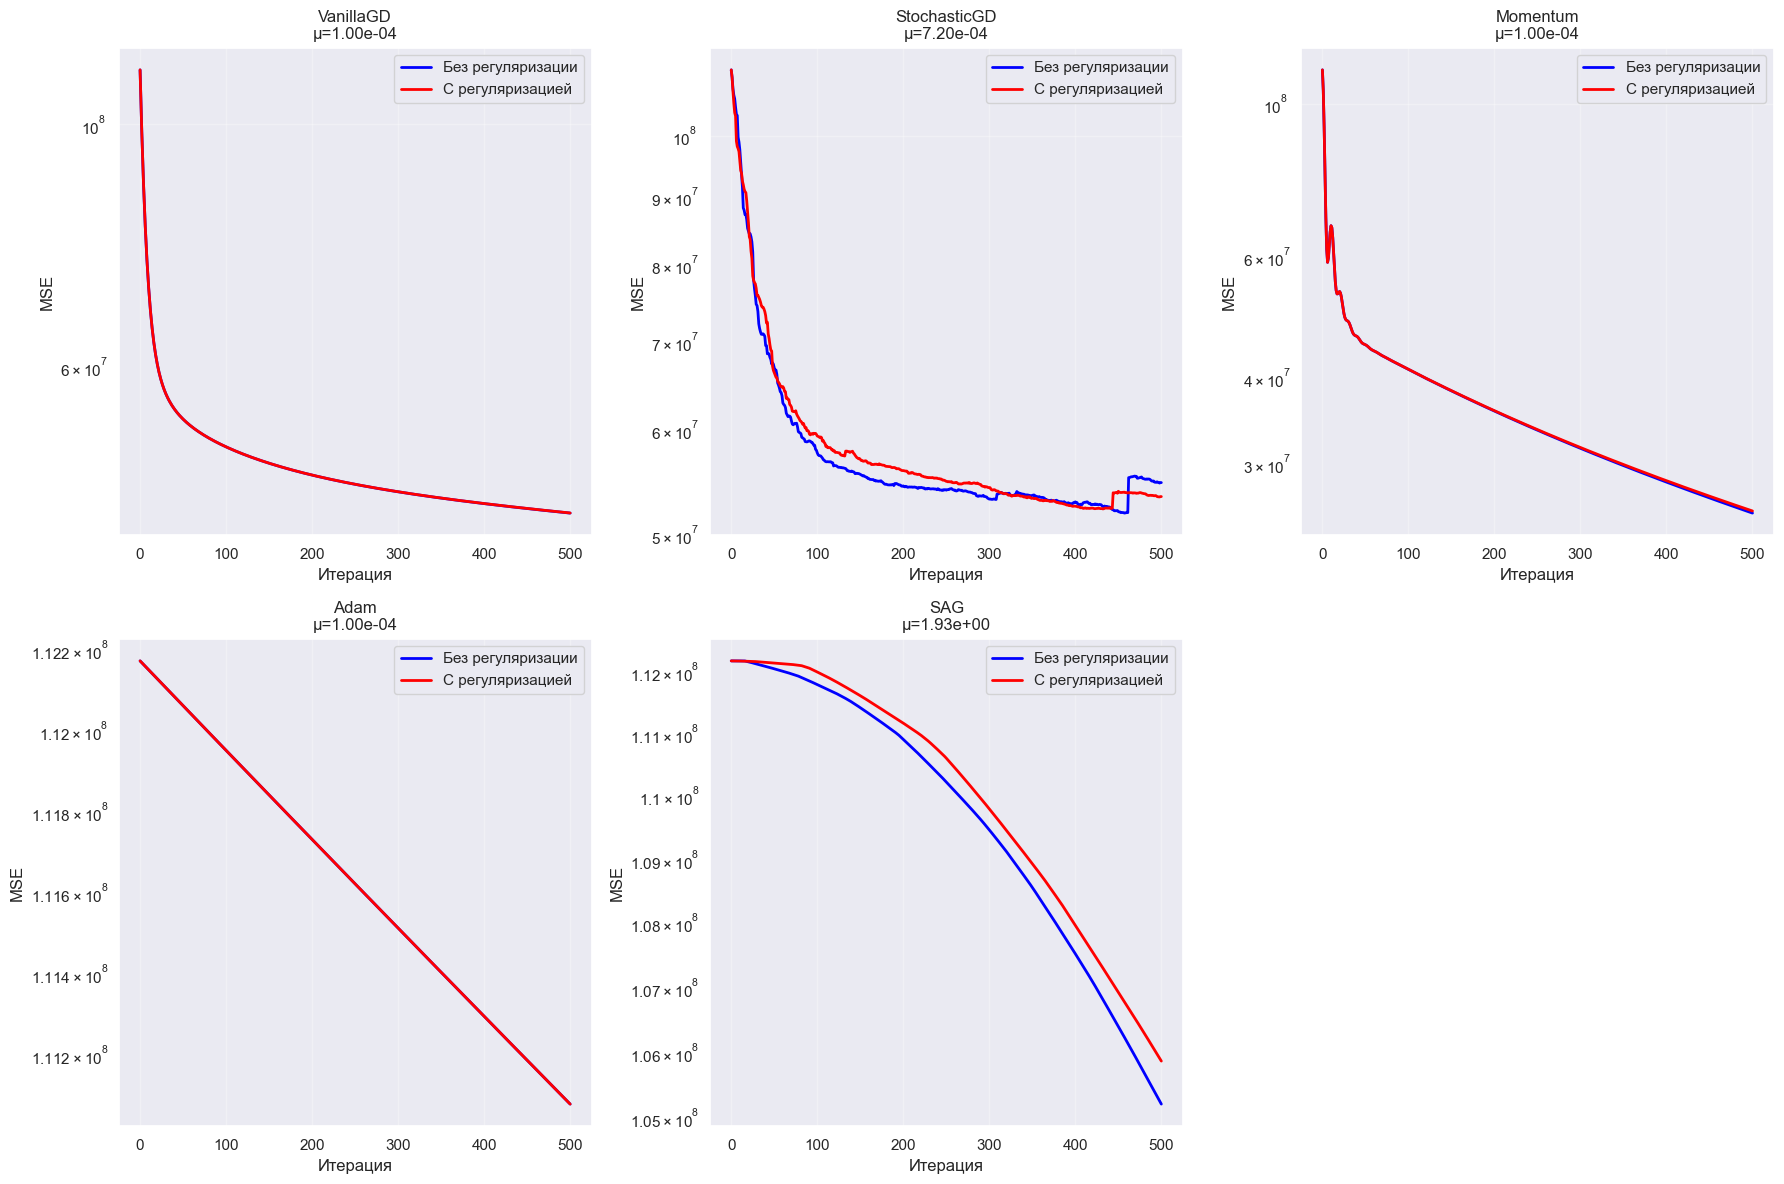


Анализ влияния регуляризации
1. Влияние на сходимость:
   - VanillaGD: количество итераций уменьшилось на 0
   - StochasticGD: количество итераций уменьшилось на 0
   - Momentum: количество итераций уменьшилось на 0
   - Adam: количество итераций уменьшилось на 0
   - SAG: количество итераций уменьшилось на 0

2. Влияние на качество:
   - VanillaGD:
     Train Loss: +0.3%
     Test Loss: +0.0%
   - StochasticGD:
     Train Loss: +9.5%
     Test Loss: +4.8%
   - Momentum:
     Train Loss: +0.9%
     Test Loss: +0.7%
   - Adam:
     Train Loss: +3.5%
     Test Loss: +0.0%
   - SAG:
     Train Loss: +0.6%
     Test Loss: -2.8%

3. Влияние на переобучение:
   - VanillaGD: разрыв train/test -132.9%
   - StochasticGD: разрыв train/test -1520.1%
   - Momentum: разрыв train/test -41.6%
   - Adam: разрыв train/test -90.8%
   - SAG: разрыв train/test -91.7%


In [28]:
import numpy as np
from tqdm import tqdm
from linear_regression import LossFunction

optimizers = {
    'VanillaGD': VanillaGradientDescent,
    'StochasticGD': StochasticGradientDescent,
    'Momentum': MomentumDescent,
    'Adam': Adam,
    'SAG': SAGDescent
}

lambda_values = np.logspace(-6, -2, 8)
mu_values = np.logspace(-4, 2, 8)

results_with_reg = {}

for opt_name, opt_class in optimizers.items():
    print(f"\nПодбор параметров для {opt_name} с регуляризацией")
    
    best_val_loss = np.inf
    best_params = None
    best_model = None

    for lambda_val in tqdm(lambda_values, desc=f"{opt_name} - lambda"):
        for mu_val in mu_values:
            try:
                class CustomConstantLR(ConstantLR):
                    def __init__(self):
                        super().__init__(lr=lambda_val)

                if opt_name == 'StochasticGD':
                    optimizer = opt_class(lr_schedule=CustomConstantLR, batch_size=32)
                elif opt_name == 'Momentum':
                    optimizer = opt_class(lr_schedule=CustomConstantLR, beta=0.9)
                elif opt_name == 'Adam':
                    optimizer = opt_class(lr_schedule=CustomConstantLR, beta1=0.9, beta2=0.999, eps=1e-8)
                else:
                    optimizer = opt_class(lr_schedule=CustomConstantLR)

                model = LinearRegression(
                    optimizer=optimizer,
                    l2_coef=mu_val, 
                    tolerance=1e-4,
                    max_iter=500,
                    loss_function=LossFunction.MSE
                )
                
                model.fit(X_train_scaled, y_train_np)

                val_loss = model.compute_loss(X_val_scaled, y_val_np)

                if val_loss < best_val_loss and np.isfinite(val_loss):
                    best_val_loss = val_loss
                    best_params = {
                        'lambda': lambda_val,
                        'mu': mu_val,
                        'val_loss': val_loss,
                        'train_loss': model.compute_loss(X_train_scaled, y_train_np),
                        'test_loss': model.compute_loss(X_test_scaled, y_test_np),
                        'train_score': model.score(X_train_scaled, y_train_np),
                        'val_score': model.score(X_val_scaled, y_val_np),
                        'test_score': model.score(X_test_scaled, y_test_np),
                        'iterations': len(model.loss_history) - 1,
                        'loss_history': model.loss_history.copy()
                    }
                    best_model = model
                    
            except Exception as e:
                continue
    
    if best_params is not None:
        results_with_reg[opt_name] = best_params
        print(f"Лучшие параметры для {opt_name}: λ={best_params['lambda']:.2e}, μ={best_params['mu']:.2e}")
        print(f"Val Loss: {best_params['val_loss']:.4f}, Iterations: {best_params['iterations']}")
    else:
        print(f"Не удалось найти валидные параметры для {opt_name}")

print("\n" + "="*80)
print("Сравение результатов с регуляризацией и без")
print("="*80)

comparison_data = []
for opt_name in optimizers.keys():
    if opt_name in results_with_reg and opt_name in results:
        reg_results = results_with_reg[opt_name]
        no_reg_results = results[opt_name]
        
        comparison_data.append({
            'Method': opt_name,
            'λ (no reg)': f"{no_reg_results['best_lr']:.2e}",
            'λ (reg)': f"{reg_results['lambda']:.2e}",
            'μ': f"{reg_results['mu']:.2e}",
            'Train Loss (no reg)': f"{no_reg_results['best_val_loss']:.4f}",
            'Train Loss (reg)': f"{reg_results['train_loss']:.4f}",
            'Test Loss (no reg)': f"{no_reg_results['best_test_loss']:.4f}",
            'Test Loss (reg)': f"{reg_results['test_loss']:.4f}",
            'Test R² (no reg)': f"{no_reg_results['best_test_score']:.4f}",
            'Test R² (reg)': f"{reg_results['test_score']:.4f}",
            'Iterations (no reg)': no_reg_results['best_iterations'],
            'Iterations (reg)': reg_results['iterations']
        })

if comparison_data:
    comparison_df = pd.DataFrame(comparison_data)
    print(comparison_df.to_string(index=False))
    
print("\n" + "="*80)
print("Графики")
print("="*80)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

colors = {'no_reg': 'blue', 'with_reg': 'red'}

for idx, opt_name in enumerate(optimizers.keys()):
    if idx >= len(axes):
        break
        
    ax = axes[idx]

    if opt_name in results:
        no_reg_losses = []
        class NoRegConstantLR(ConstantLR):
            def __init__(self):
                super().__init__(lr=results[opt_name]['best_lr'])
        
        if opt_name == 'StochasticGD':
            optimizer_no_reg = optimizers[opt_name](lr_schedule=NoRegConstantLR, batch_size=32)
        elif opt_name == 'Momentum':
            optimizer_no_reg = optimizers[opt_name](lr_schedule=NoRegConstantLR, beta=0.9)
        elif opt_name == 'Adam':
            optimizer_no_reg = optimizers[opt_name](lr_schedule=NoRegConstantLR, beta1=0.9, beta2=0.999, eps=1e-8)
        else:
            optimizer_no_reg = optimizers[opt_name](lr_schedule=NoRegConstantLR)
        
        model_no_reg = LinearRegression(
            optimizer=optimizer_no_reg,
            l2_coef=0.0,
            tolerance=1e-4,
            max_iter=500,
            loss_function=LossFunction.MSE
        )
        
        model_no_reg.fit(X_train_scaled, y_train_np)
        no_reg_losses = model_no_reg.loss_history

        if opt_name in results_with_reg:
            with_reg_losses = results_with_reg[opt_name]['loss_history']

            iterations_no_reg = range(len(no_reg_losses))
            iterations_with_reg = range(len(with_reg_losses))
            
            ax.plot(iterations_no_reg, no_reg_losses, 
                   label='Без регуляризации', color=colors['no_reg'], linewidth=2)
            ax.plot(iterations_with_reg, with_reg_losses, 
                   label='С регуляризацией', color=colors['with_reg'], linewidth=2)
            
            ax.set_title(f'{opt_name}\nμ={results_with_reg[opt_name]["mu"]:.2e}')
            ax.set_xlabel('Итерация')
            ax.set_ylabel('MSE')
            ax.legend()
            ax.grid(True, alpha=0.3)
            ax.set_yscale('log')

for idx in range(len(optimizers), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("Анализ влияния регуляризации")
print("="*80)

if comparison_data:
    print("1. Влияние на сходимость:")
    for data in comparison_data:
        iter_change = data['Iterations (reg)'] - data['Iterations (no reg)']
        change_str = "увеличилось" if iter_change > 0 else "уменьшилось"
        print(f"   - {data['Method']}: количество итераций {change_str} на {abs(iter_change)}")
    
    print("\n2. Влияние на качество:")
    for data in comparison_data:
        train_loss_no_reg = float(data['Train Loss (no reg)'])
        train_loss_reg = float(data['Train Loss (reg)'])
        test_loss_no_reg = float(data['Test Loss (no reg)'])
        test_loss_reg = float(data['Test Loss (reg)'])
        
        train_change = (train_loss_reg - train_loss_no_reg) / train_loss_no_reg * 100
        test_change = (test_loss_reg - test_loss_no_reg) / test_loss_no_reg * 100
        
        print(f"   - {data['Method']}:")
        print(f"     Train Loss: {train_change:+.1f}%")
        print(f"     Test Loss: {test_change:+.1f}%")
    
    print("\n3. Влияние на переобучение:")
    for data in comparison_data:
        train_loss_no_reg = float(data['Train Loss (no reg)'])
        test_loss_no_reg = float(data['Test Loss (no reg)'])
        train_loss_reg = float(data['Train Loss (reg)'])
        test_loss_reg = float(data['Test Loss (reg)'])
        
        gap_no_reg = test_loss_no_reg - train_loss_no_reg
        gap_reg = test_loss_reg - train_loss_reg
        gap_change = (gap_reg - gap_no_reg) / gap_no_reg * 100
        
        print(f"   - {data['Method']}: разрыв train/test {gap_change:+.1f}%")